In [1]:
import sys
sys.path.append('../xrun')

In [2]:
import re

from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

from IPython.core.display import HTML
from sklearn.metrics import pairwise_distances

from xrun.data.run_info import RunInfo

In [3]:
def load_cost_from_file(file_path: Path):
    if file_path.exists():
            with open(file_path, "r") as f:
                return float(f.read())
    else:
        print(f"Warning: {file_path} not found!")
    return None

def get_algorithm_name(run_info):
    if run_info.algorithm == "basic-clustering":
        return "StreamKM++"
    elif run_info.algorithm == "sensitivity-sampling":
        return "Sensitivity Sampling"
    elif run_info.algorithm == "group-sampling":
        return "Group Sampling"
    elif run_info.algorithm == "bico":
        return "BICO"
    return "Unknown"

def get_dataset_print_name(run_info):
    d = {
        "census": "Census",
        "censuslowd": "Census+PCA",
        "covertype": "Covertype",
        "covertypelowd": "Covertype+PCA",
        "tower": "Tower",
        "hardinstanceb1": "Benchmark",
        "hardinstanceb2": "Benchmark-2.0",
    }
    if run_info.dataset in d:
        return d[run_info.dataset]
    return run_info.dataset
    

def get_costs(file_paths):
    costs = []
    for index, run_file_path in enumerate(file_paths):
        run_info = RunInfo.load_json(run_file_path)
        if "hardinstance" in run_info.dataset and run_info.k > 40:
            continue
        real_cost = load_cost_from_file(run_file_path.parent / "real_cost.txt")
        coreset_cost = load_cost_from_file(run_file_path.parent / "coreset_cost.txt")
        distortion = None
        if real_cost is not None and coreset_cost is not None:
            distortion = max(float(real_cost/coreset_cost), float(coreset_cost/real_cost))
        costs.append({
            "dataset": get_dataset_print_name(run_info),
            "algorithm": get_algorithm_name(run_info),
            "k": run_info.k,
            "running_time": int(run_info.duration_secs),
            "real_cost": real_cost,
            "coreset_cost": coreset_cost,
            "distortion": distortion,
            "run_file_path": str(run_file_path),
        })
    df_data = pd.DataFrame(costs)
    return df_data.groupby(["dataset", "algorithm", "k"], as_index=False).head(10)

def aggregate_costs(df_costs: pd.DataFrame):
    group_columns = ["dataset", "algorithm", "k"]
    df_top_k = df_costs.groupby(group_columns, as_index=False).head(10)
    df_aggr_costs = df_top_k.groupby(group_columns, as_index=False).agg(
        experiment_count=("algorithm", "count"),
        real_cost_mean=("real_cost", "mean"),
        real_cost_std=("real_cost", "std"),
        coreset_cost_mean=("coreset_cost", "mean"),
        coreset_cost_std=("coreset_cost", "std"),
        running_time_mean=("running_time", "mean"),
        running_time_std=("running_time", "std"),
        distortion_mean=("distortion", "mean"),
        distortion_std=("distortion", "std"),
    )
    df_aggr_costs["running_time"] = pd.to_timedelta(df_aggr_costs.running_time_mean, unit='s')
    df_aggr_costs["running_time_formatted"] = df_aggr_costs["running_time"].map(
        lambda x: f"{x.components.hours:02d}h {x.components.minutes:02d}m {x.components.seconds:02d}s"
    )
    return df_aggr_costs


def display_results_for(df_aggr_costs: pd.DataFrame, dataset_name: str, show_counts: bool=True, show_running_times:bool=True, show_costs: bool=True):
    pd.set_option('display.float_format', '{:.2e}'.format)
    
    display(HTML(f"<h2 style='border-bottom:solid 1px Black;padding-bottom:5px;'>Results for {dataset_name}</h2>"))
    df_filtered = df_aggr_costs[df_aggr_costs.dataset == dataset_name]
    
    html_str = ""
    
    if show_counts:
        df_counts = pd.pivot_table(df_filtered, values="experiment_count", index=["algorithm"], columns=["k"])
        df_counts = df_counts.rename_axis(None, axis=0).rename_axis(None, axis=1)
        html_str += f'<div style="border:solid 1px White; width:300px;float:left;">'
        html_str += f"<h4 style='text-align:center;'>Experiment Counts</h4>"
        html_str += df_counts.style.format(precision=0).to_html()
        html_str += "</div>"
    
    if show_running_times:
        df_run_times = pd.pivot_table(df_filtered, values="running_time_formatted", index=["algorithm"], columns=["k"], aggfunc=lambda x: x)
        df_run_times = df_run_times.rename_axis(None, axis=0).rename_axis(None, axis=1)

        html_str += f'<div style="border:solid 1px White; float:left;">'
        html_str += f"<h4 style='text-align:center;'>Average Running Times</h4>"
        html_str += df_run_times.to_html()
        html_str += "</div>"
        
    display(HTML(html_str))

    if show_costs:
        df_real_costs = pd.pivot_table(df_filtered, values="real_cost_mean", index=["algorithm"], columns=["k"])
        df_real_costs = df_real_costs.rename_axis(None, axis=0).rename_axis(None, axis=1)
        
        df_coreset_costs = pd.pivot_table(df_filtered, values="coreset_cost_mean", index=["algorithm"], columns=["k"])
        df_coreset_costs = df_coreset_costs.rename_axis(None, axis=0).rename_axis(None, axis=1)
        
        html_str = ""
        html_str += f'<div style="border:solid 1px #eee; float:left;">'
        html_str += f"<h4 style='text-align:center;'>Real costs</h4>"
        html_str += df_real_costs.to_html()
        html_str += "</div>"
        
        html_str += f'<div style="border:solid 1px #eee; float:left;">'
        html_str += f"<h4 style='text-align:center;'>Coreset costs</h4>"
        html_str += df_coreset_costs.to_html()
        html_str += "</div>"
        display(HTML(html_str))
    
    display(HTML(f'<h4>Distortions</h4>'))
    df_distortions = pd.pivot_table(df_filtered, values="distortion_mean", index=["algorithm"], columns=["k"])
    df_distortions = df_distortions.rename_axis(None, axis=0).rename_axis(None, axis=1)
    display(df_distortions)

In [4]:
data_results_dir = Path("../data/odin-results/")
run_files = list(data_results_dir.glob("**/*.json"))

In [5]:
run_files.extend(list(Path("../data/cary-results/hardinstanceb1").glob("**/*.json")))
run_files.extend(list(Path("../data/cary-results/hardinstanceb2").glob("**/*.json")))

In [6]:
len(run_files)

2394

In [7]:
df_cost_data = get_costs(run_files)

In [9]:
df_aggr_costs = aggregate_costs(df_cost_data)

In [14]:
for dataset_name in df_aggr_costs.dataset.unique():
    display_results_for(df_aggr_costs, dataset_name=dataset_name, show_counts=True, show_running_times=False, show_costs=False)

,10,20,30,40
BICO,10,10,10,10
Group Sampling,10,10,10,10
Sensitivity Sampling,10,10,10,10
StreamKM++,10,10,10,9


,10,20,30,40
BICO,3.85e+00,3.80e+00,3.31e+00,4.01e+00
Group Sampling,1.01e+00,1.01e+00,1.01e+00,1.01e+00
Sensitivity Sampling,1.00e+00,1.01e+00,1.00e+00,1.00e+00
StreamKM++,2.50e+00,2.81e+00,2.42e+00,2.86e+00


,10,20,30,40
BICO,10,10,10,10
Group Sampling,10,10,10,10
Sensitivity Sampling,10,10,10,10
StreamKM++,9,9,9,9


,10,20,30,40
BICO,1.11e+00,1.27e+00,1.25e+00,1.24e+00
Group Sampling,1.01e+00,1.01e+00,1.01e+00,1.01e+00
Sensitivity Sampling,1.00e+00,1.00e+00,1.00e+00,1.00e+00
StreamKM++,1.06e+00,1.20e+00,1.23e+00,1.21e+00


,10,20,30,40,50
BICO,10,10,10,10,10
Group Sampling,10,10,10,10,10
Sensitivity Sampling,10,10,10,10,10
StreamKM++,10,10,10,10,10


,10,20,30,40,50
BICO,1.64e+00,1.73e+00,1.77e+00,1.83e+00,1.87e+00
Group Sampling,1.02e+00,1.02e+00,1.02e+00,1.02e+00,1.02e+00
Sensitivity Sampling,1.01e+00,1.01e+00,1.01e+00,1.00e+00,1.01e+00
StreamKM++,1.22e+00,1.25e+00,1.27e+00,1.28e+00,1.29e+00


,10,20,30,40,50
BICO,10,10,10,10,10
Group Sampling,10,10,10,10,10
Sensitivity Sampling,10,10,10,10,10
StreamKM++,10,10,10,10,10


,10,20,30,40,50
BICO,1.18e+00,1.44e+00,1.65e+00,1.79e+00,1.85e+00
Group Sampling,1.01e+00,1.02e+00,1.02e+00,1.02e+00,1.02e+00
Sensitivity Sampling,1.01e+00,1.01e+00,1.01e+00,1.00e+00,1.00e+00
StreamKM++,1.05e+00,1.14e+00,1.21e+00,1.26e+00,1.29e+00


,10,20,30,40,50
BICO,10,10,10,10,10
Group Sampling,10,10,10,10,10
Sensitivity Sampling,10,10,10,10,10
StreamKM++,10,10,10,10,10


,10,20,30,40,50
BICO,1.10e+00,1.11e+00,1.10e+00,1.09e+00,1.07e+00
Group Sampling,1.02e+00,1.03e+00,1.02e+00,1.02e+00,1.03e+00
Sensitivity Sampling,1.01e+00,1.01e+00,1.01e+00,1.01e+00,1.00e+00
StreamKM++,1.04e+00,1.04e+00,1.04e+00,1.04e+00,1.04e+00


,10,20,30,40,50
BICO,10,10,10,10,10
Group Sampling,10,10,10,10,10
Sensitivity Sampling,10,10,10,10,10
StreamKM++,10,10,10,10,10


,10,20,30,40,50
BICO,1.10e+00,1.11e+00,1.10e+00,1.09e+00,1.07e+00
Group Sampling,1.02e+00,1.02e+00,1.03e+00,1.02e+00,1.02e+00
Sensitivity Sampling,1.01e+00,1.01e+00,1.01e+00,1.01e+00,1.00e+00
StreamKM++,1.04e+00,1.04e+00,1.04e+00,1.04e+00,1.04e+00


,20,40,60,80,100
BICO,10,10,10,10,10
Group Sampling,10,10,10,10,10
Sensitivity Sampling,10,10,10,10,10
StreamKM++,10,10,10,10,10


,20,40,60,80,100
BICO,1.06e+00,1.06e+00,1.06e+00,1.05e+00,1.04e+00
Group Sampling,1.01e+00,1.02e+00,1.03e+00,1.03e+00,1.03e+00
Sensitivity Sampling,1.01e+00,1.01e+00,1.01e+00,1.01e+00,1.00e+00
StreamKM++,1.02e+00,1.02e+00,1.01e+00,1.01e+00,1.01e+00


,20,30,40,50
StreamKM++,2,4,4,4


,20,30,40,50
StreamKM++,1.19e+00,1.13e+00,1.09e+00,1.07e+00


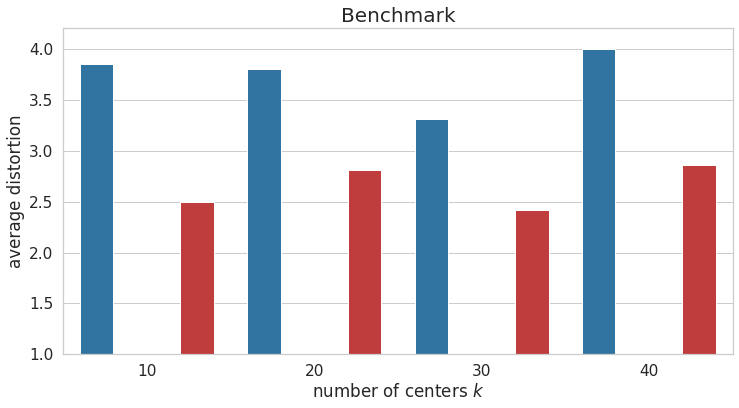

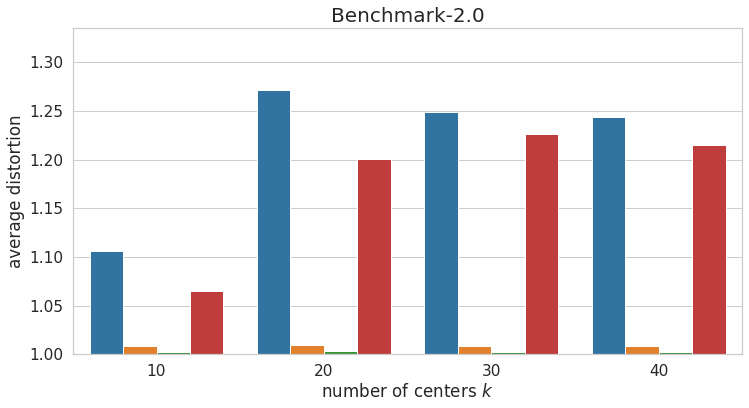

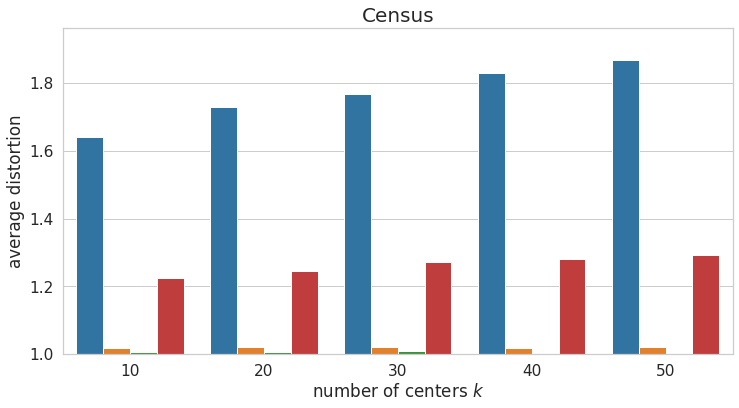

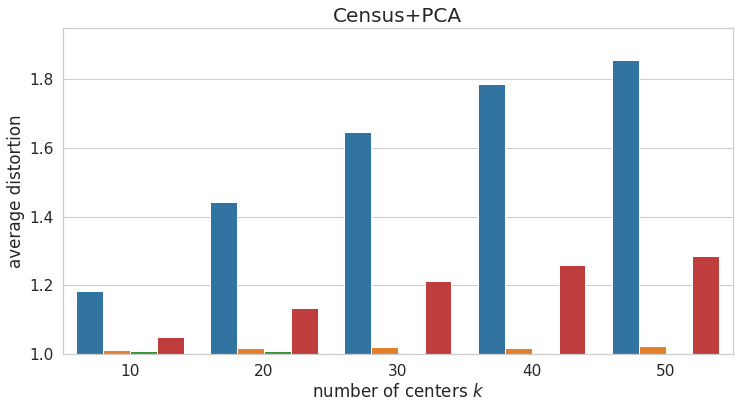

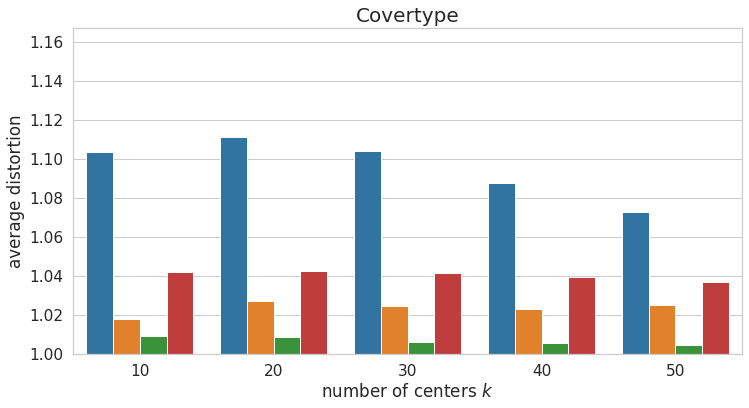

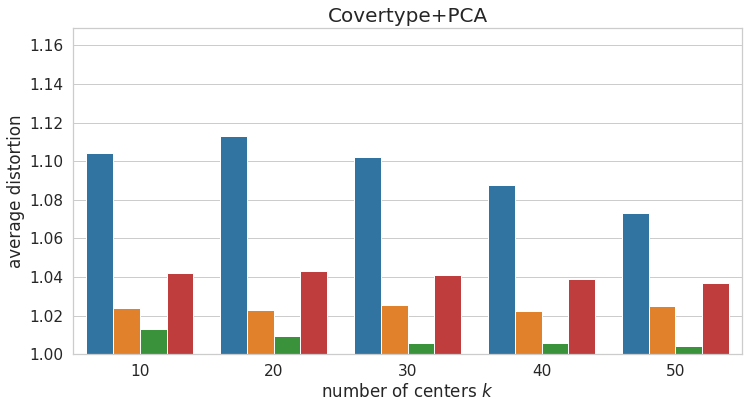

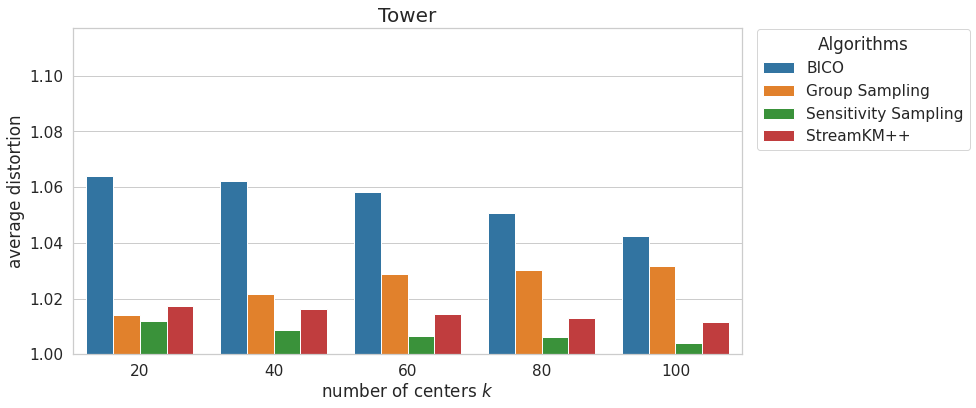

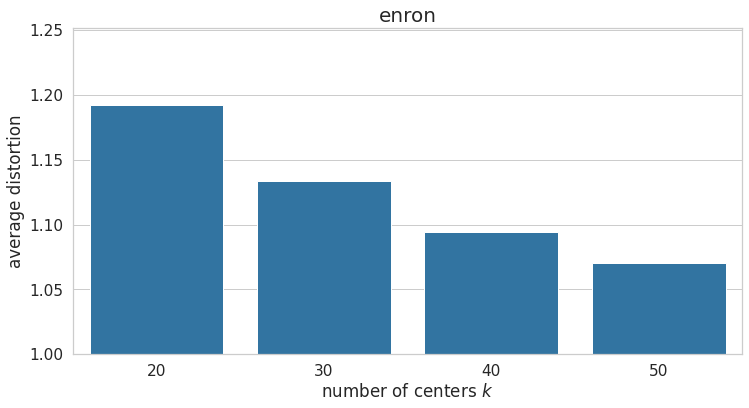

In [11]:
with sns.plotting_context("notebook", font_scale=1.4):
    for dataset in df_aggr_costs.dataset.unique():
        is_tower = dataset == "Tower"
        df_filtered = df_aggr_costs[df_aggr_costs.dataset == dataset]
        fig, ax = plt.subplots(figsize=(12, 6))
        sns.barplot(data=df_filtered, x="k", y="distortion_mean", hue="algorithm", ax=ax, palette=sns.color_palette("tab10"))
        ax.set_title(f"{dataset}", fontdict={"size": 20})
        ax.set_ylabel("average distortion")
        ax.set_xlabel("number of centers $k$")
        ax.set_ylim(bottom=1)
        if is_tower:
            ax.legend(title='Algorithms', bbox_to_anchor=(1.01, 1.02), loc='upper left')
        else:
            ax.get_legend().remove()
        fig.savefig(f"figures/distortions-{dataset}.pdf", bbox_inches="tight")

In [12]:
df_aggr_costs

,dataset,algorithm,k,experiment_count,real_cost_mean,real_cost_std,coreset_cost_mean,coreset_cost_std,running_time_mean,running_time_std,distortion_mean,distortion_std,running_time,running_time_formatted
0,Benchmark,BICO,10,10,4.83e+06,3.78e+04,1.27e+06,1.32e+05,1.94e+01,3.84e+00,3.85e+00,4.62e-01,0 days 00:00:19.400000,00h 00m 19s
1,Benchmark,BICO,20,10,1.34e+07,4.34e+04,3.52e+06,1.65e+05,1.54e+02,7.29e+00,3.80e+00,1.81e-01,0 days 00:02:33.700000,00h 02m 33s
2,Benchmark,BICO,30,10,2.61e+06,1.14e+04,7.90e+05,2.82e+04,4.42e+01,1.23e+00,3.31e+00,1.22e-01,0 days 00:00:44.200000,00h 00m 44s
3,Benchmark,BICO,40,10,8.28e+06,6.17e+04,2.07e+06,1.05e+05,1.58e+02,8.80e+00,4.01e+00,1.92e-01,0 days 00:02:38.100000,00h 02m 38s
4,Benchmark,Group Sampling,10,10,4.63e+06,4.06e+04,4.58e+06,3.82e+04,4.10e+02,5.93e+01,1.01e+00,1.05e-03,0 days 00:06:50.100000,00h 06m 50s
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,Tower,StreamKM++,100,10,1.63e+08,6.71e+05,1.61e+08,6.73e+05,3.49e+04,2.77e+03,1.01e+00,2.72e-04,0 days 09:41:00.200000,09h 41m 00s
132,enron,StreamKM++,20,2,2.12e+07,1.72e+05,1.78e+07,2.34e+05,1.73e+05,1.41e+03,1.19e+00,6.04e-03,2 days 00:09:57,00h 09m 57s
133,enron,StreamKM++,30,4,1.99e+07,2.85e+05,1.75e+07,2.66e+05,2.67e+05,3.60e+03,1.13e+00,1.27e-03,3 days 02:06:27.750000,02h 06m 27s
134,enron,StreamKM++,40,4,1.95e+07,2.88e+05,1.78e+07,2.86e+05,3.54e+05,3.39e+03,1.09e+00,1.61e-03,4 days 02:19:29.500000,02h 19m 29s


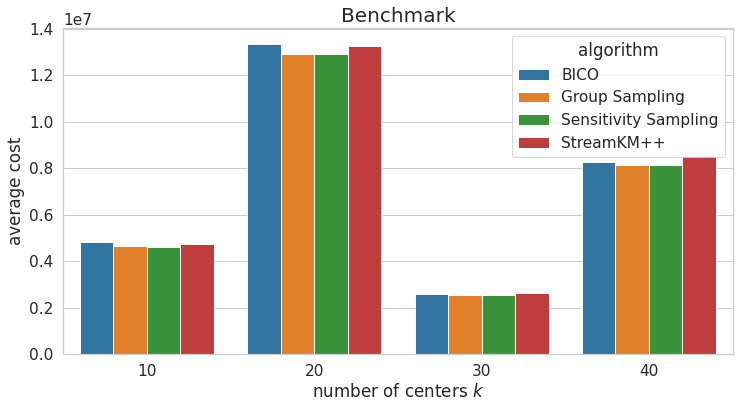

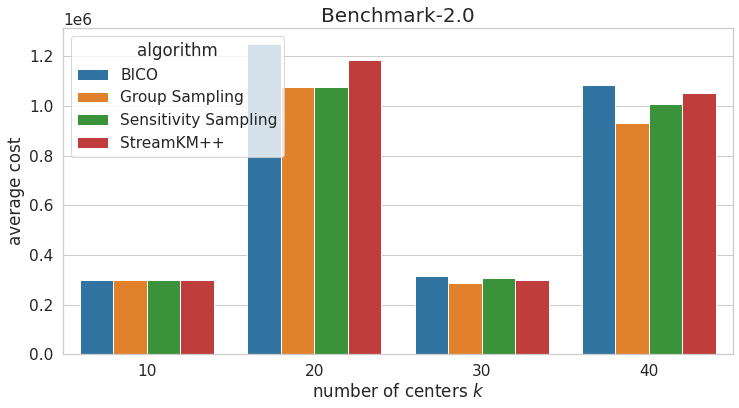

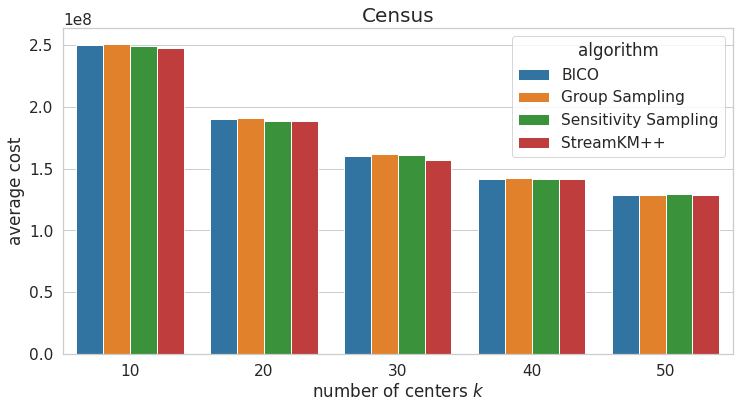

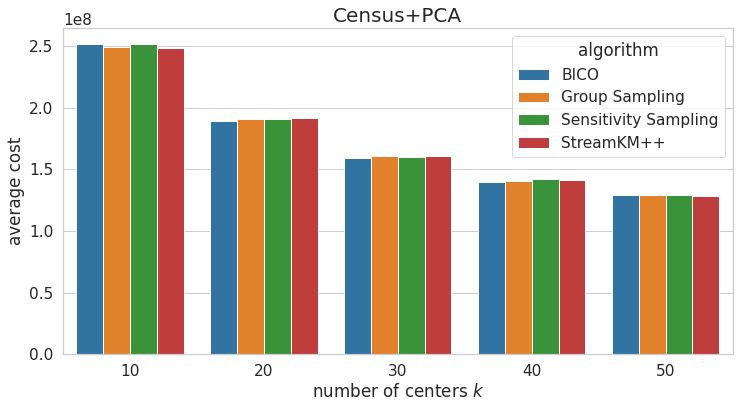

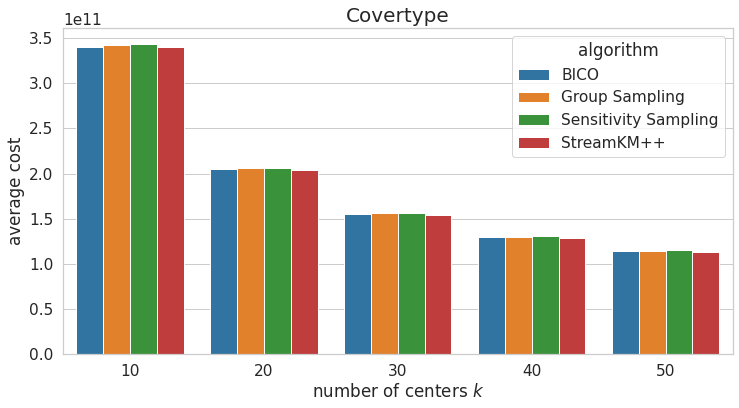

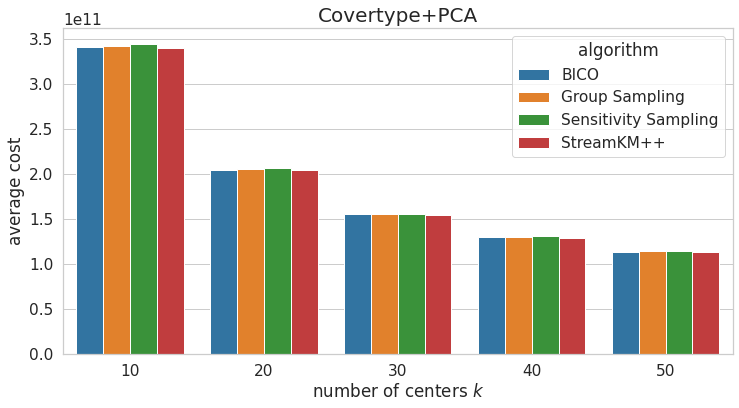

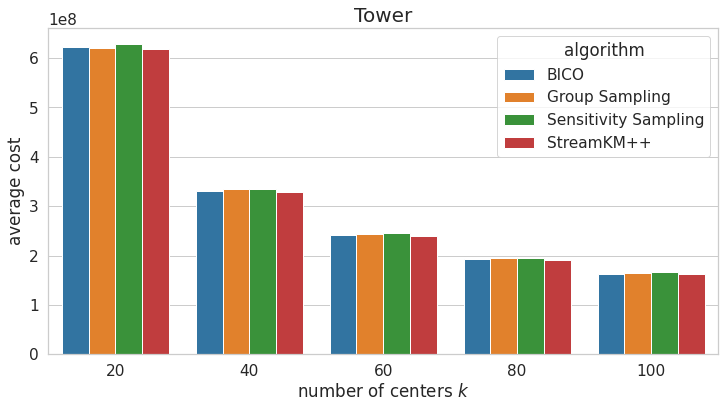

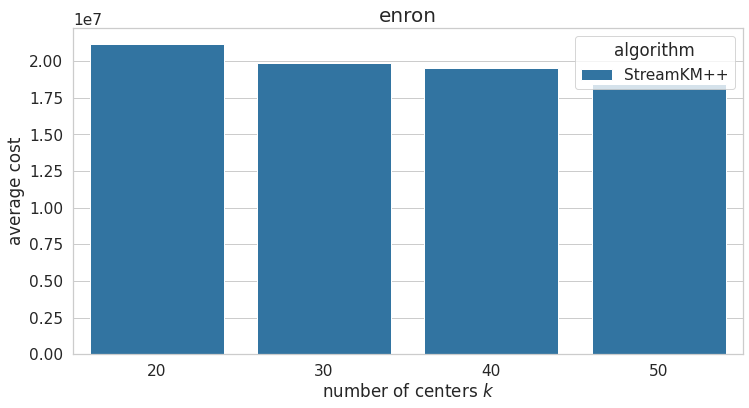

In [13]:
with sns.plotting_context("notebook", font_scale=1.4):
    for dataset in df_aggr_costs.dataset.unique():
        is_tower = dataset == "Tower"
        df_filtered = df_aggr_costs[df_aggr_costs.dataset == dataset]
        fig, ax = plt.subplots(figsize=(12, 6))
        sns.barplot(data=df_filtered, x="k", y="real_cost_mean", hue="algorithm", ax=ax, palette=sns.color_palette("tab10"))
        ax.set_title(f"{dataset}", fontdict={"size": 20})
        ax.set_ylabel("average cost")
        ax.set_xlabel("number of centers $k$")
        fig.savefig(f"figures/costs-{dataset}.pdf", bbox_inches="tight")